# CIFAR10 딥러닝 모델

## 데이터 로드 및 전처리

CIFAR10 데이터셋을 로드하고, 훈련 데이터셋에서 20%를 검증 데이터셋으로 분리합니다. 데이터셋은 keras.datasets에서 불러올 수 있는 CIFAR10 데이터 셋을 활용합니다.
데이터셋 분리 작업에서는 sklearn 라이브러리의 train_test_split 함수를 활용합니다.
훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력합니다.

In [15]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras.datasets import cifar10
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout


In [16]:
# 문제 3-1: cifar10 데이터셋을 로드하고, 훈련 데이터셋에서 20%를 검증 데이터셋으로 분리합니다.
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=42)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력
print("전체 학습 데이터: {} 레이블: {}".format(x_train_full.shape, y_train_full.shape))
print("학습 데이터: {} 레이블: {}".format(x_train.shape, y_train.shape))
print("검증 데이터: {} 레이블: {}".format(x_val.shape, y_val.shape))
print("테스트 데이터: {} 레이블: {}".format(x_test.shape, y_test.shape))


전체 학습 데이터: (50000, 32, 32, 3) 레이블: (50000, 1)
학습 데이터: (40000, 32, 32, 3) 레이블: (40000, 1)
검증 데이터: (10000, 32, 32, 3) 레이블: (10000, 1)
테스트 데이터: (10000, 32, 32, 3) 레이블: (10000, 1)


In [17]:
# cifar10의 분류에 해당하는 'airplane', 'automobile', 'bird', 'cat', 'deer', 
# 'dog', 'frog', 'horse', 'ship', 'truck'를 class_name으로 정의합니다.
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [18]:
# 라벨
from tensorflow.keras import utils

y_train = utils.to_categorical(y_train)
y_val = utils.to_categorical(y_val)
y_test = utils.to_categorical(y_test)

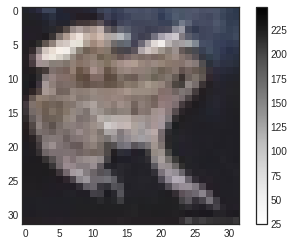

In [19]:
# 훈련 데이터의 0번째인 x_train[0]를 이미지로 시각화합니다.
plt.style.use('seaborn-white')

plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.show()

In [20]:
# 훈련, 검증, 테스트 데이터의 형태(shape)을 출력합니다.
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [21]:
# 문제 3-2: 훈련, 검증, 테스트 데이터의 형태(shape)을 32 * 32 * 3 = 3072로 변형합니다.
x_train = x_train.reshape(x_train.shape[0], 32 * 32 * 3)
x_val = x_val.reshape(x_val.shape[0], 32 * 32 * 3)
x_test = x_test.reshape(x_test.shape[0], 32 * 32 * 3)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(40000, 3072)
(10000, 3072)
(10000, 3072)


In [22]:
# 훈련, 검증, 테스트 데이터를 255로 나누어 0~1 사이의 값으로 변환합니다.
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

## 모델 구성 및 컴파일
BatchNormalization과 Dropout을 적용하여 빠르게 학습하면서 과대적합을 방지하고, 10개의 이미지를 분류하는 딥러닝 모델을 구성합니다.

In [23]:
# 문제 3-3: BatchNormalization과 Dropout을 적용하여 빠른 학습과 과대적합을 방지하고,
# 10개의 이미지를 분류하는 딥러닝 모델을 구성합니다.
# input_shape
input_shape = (32 * 32 * 3,)

# 딥러닝 모델 구성
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

# 모델 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer='adam', # adam
              metrics=['accuracy'])

# 모델 요약 정보 출력
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               393344    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

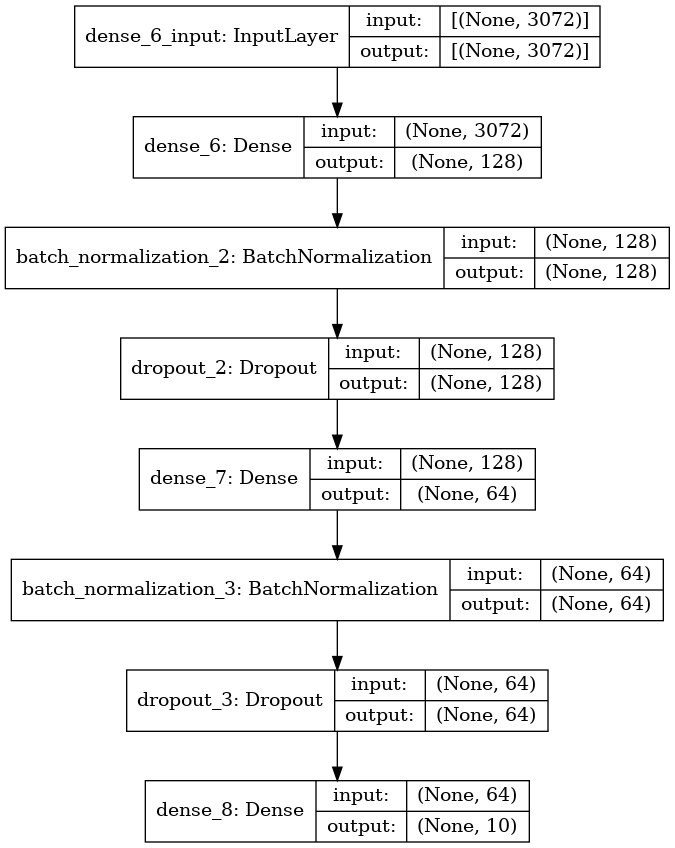

In [24]:
utils.plot_model(model, show_shapes=True)

## 모델 학습
ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.

In [25]:
# 문제 3-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
checkpoint_callback = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint_callback, early_stopping_callback])


Epoch 1/100
79/79 [==============================] - 2s 13ms/step - loss: 2.1803 - accuracy: 0.2686 - val_loss: 2.0128 - val_accuracy: 0.2923

Epoch 00001: val_loss improved from inf to 2.01283, saving model to best_model.h5
Epoch 2/100
79/79 [==============================] - 1s 7ms/step - loss: 1.9098 - accuracy: 0.3331 - val_loss: 1.7834 - val_accuracy: 0.3532

Epoch 00002: val_loss improved from 2.01283 to 1.78336, saving model to best_model.h5
Epoch 3/100
79/79 [==============================] - 1s 7ms/step - loss: 1.8112 - accuracy: 0.3591 - val_loss: 1.9417 - val_accuracy: 0.3077

Epoch 00003: val_loss did not improve from 1.78336
Epoch 4/100
79/79 [==============================] - 1s 7ms/step - loss: 1.7526 - accuracy: 0.3769 - val_loss: 2.0731 - val_accuracy: 0.2894

Epoch 00004: val_loss did not improve from 1.78336
Epoch 5/100
79/79 [==============================] - 1s 7ms/step - loss: 1.7307 - accuracy: 0.3855 - val_loss: 1.7962 - val_accuracy: 0.3571

Epoch 00005: val_lo

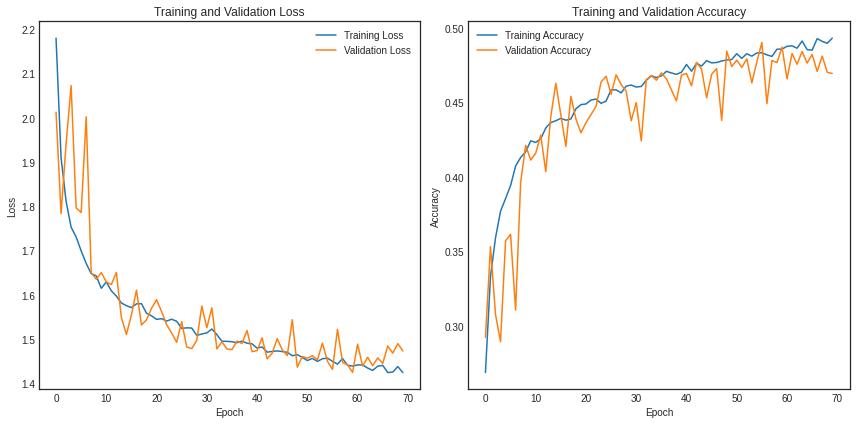

In [26]:
# 문제 3-5: 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 모델 평가 및 예측
테스트 데이터셋을 이용해 모델을 평가합니다.





In [27]:
# 테스트 데이터셋을 이용해 모델을 평가합니다.
loss, accuracy = model.evaluate(x_test, y_test)
print(f"테스트 데이터 정확도: {accuracy}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4262 - accuracy: 0.4920
테스트 데이터 정확도: 0.492000013589859


In [28]:
from sklearn.metrics import classification_report

# 테스트 데이터셋에 대한 예측 결과 얻기
predictions = model.predict(x_test)

# 예측 결과의 인덱스 값으로 변환
predicted_labels = np.argmax(predictions, axis=1)

# classification report 생성
report = classification_report(np.argmax(y_test, axis=1), predicted_labels)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.51      0.56      1000
           1       0.64      0.59      0.61      1000
           2       0.36      0.38      0.37      1000
           3       0.40      0.23      0.29      1000
           4       0.45      0.35      0.40      1000
           5       0.42      0.40      0.41      1000
           6       0.50      0.58      0.54      1000
           7       0.42      0.68      0.52      1000
           8       0.58      0.64      0.61      1000
           9       0.55      0.56      0.55      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000

